# Neural Network Modeling

In [73]:
from pyimagesearch import config
from pyimagesearch.resnet import ResNet
from imutils import paths
import random
import shutil
import os
import cv2
import re
from itertools import chain
from tqdm import tqdm
import pydot
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report

import tensorflow as tf
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import BatchNormalization, Dropout, Flatten, Dense, Embedding, GlobalMaxPool1D, GlobalAveragePooling2D, Conv2D, MaxPooling2D, LSTM, Reshape, SpatialDropout1D
from keras import regularizers
from keras.layers.merge import average, concatenate
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from keras import backend as K

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('clean_features.csv')
df.head()

,PetID,Type,Age,Gender,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,...,10,11,12,13,14,15,16,17,18,19
0,86e1089a3,2,3,1,1,1,2,2,2,1,...,0.009754,-0.002826,-0.018925,-0.012456,0.000584,-0.014139,-0.007550,0.018987,0.009588,0.009349
1,6296e909a,2,1,1,2,2,3,3,3,1,...,-0.010259,0.008178,0.010272,0.003087,-0.001423,-0.005038,-0.003081,0.009825,0.003104,0.006718
2,3422e4906,1,1,1,2,2,1,1,2,1,...,0.044125,-0.050633,0.041106,0.008243,0.024158,-0.030801,0.012797,-0.050066,-0.023363,-0.057766
3,5842f1ff5,1,4,2,2,1,1,1,2,1,...,-0.000498,0.044688,-0.034980,0.002213,-0.094938,0.060292,0.026551,-0.040345,-0.087958,0.000022
4,850a43f90,1,1,1,2,1,2,2,2,1,...,-0.009017,0.015145,0.099046,0.026728,0.011302,0.002314,0.000365,0.017789,0.066420,0.038391


In [4]:
pet = pd.read_csv('data/train/train.csv')
pet.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [5]:
adoption = dict(zip(df.PetID, df.AdoptionSpeed))

In [6]:
# # categorize images based on pet id
# src = 'data/train_images'
# dest = 'data/images_category'

# if not os.path.exists(dest):
#     os.makedirs(dest)

# for dirpath, dirs, files in os.walk(src):
#     for file in files:
#         if file.split('-')[1].split('.')[0] == '1':
#             pet_id = file.split('-')[0]
#             speed = str(adoption[pet_id])
#             newDir = os.path.join(dest, speed)

#             if not os.path.exists(newDir):
#                 print("[INFO] 'creating {}' directory".format(newDir))
#                 os.makedirs(newDir)

#             shutil.copy2(os.path.join(dirpath, file), newDir)

In [7]:
# train, val, test split
X = df.drop('AdoptionSpeed', axis=1).set_index('PetID')
y = df[['PetID', 'AdoptionSpeed']].set_index('PetID')

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.1, random_state=42)

In [8]:
X_train.sort_index(inplace=True)
y_train.sort_index(inplace=True)
X_val.sort_index(inplace=True)
y_val.sort_index(inplace=True)
X_test.sort_index(inplace=True)
y_test.sort_index(inplace=True)

In [9]:
y_cat_train = np_utils.to_categorical(y_train, 5)
y_cat_val = np_utils.to_categorical(y_val, 5)
y_cat_test = np_utils.to_categorical(y_test, 5)

In [10]:
# train, val, test pet id
train_id = dict((pet_id, 'training') for pet_id in X_train.index)
val_id = dict((pet_id, 'validation') for pet_id in X_val.index)
test_id = dict((pet_id, 'testing') for pet_id in X_test.index)

In [11]:
# # train, val, test images assignment

# # initialize the path to the *original* input directory of images
# ORIG_INPUT_DATASET = 'data/images_category'

# # initialize the base path to the *new* directory that will contain our images after computing the training and testing split
# BASE_PATH = 'data'

# # derive the training, validation, and testing directories
# TRAIN_PATH = os.path.sep.join([BASE_PATH, 'training'])
# VAL_PATH = os.path.sep.join([BASE_PATH, 'validation'])
# TEST_PATH = os.path.sep.join([BASE_PATH, 'testing'])

# # grab the paths to all input images in the original input directory
# imagePaths = list(paths.list_images(config.ORIG_INPUT_DATASET))

In [12]:
# # compute the training and testing split
# trainPaths = []
# valPaths = []
# testPaths = []

# for img in imagePaths:
#     if img.split('\\')[-1].split('-')[0] in train_id:
#         trainPaths.append(img)
#     elif img.split('\\')[-1].split('-')[0] in val_id:
#         valPaths.append(img)
#     elif img.split('\\')[-1].split('-')[0] in test_id:
#         testPaths.append(img)
        
# print('number of train images: '+str(len(trainPaths)))
# print('number of validation images: '+str(len(valPaths)))
# print('number of test images: '+str(len(testPaths)))

In [13]:
# # define the datasets that we'll be building
# datasets = [
#     ('training', trainPaths, config.TRAIN_PATH),
#     ('validation', valPaths, config.VAL_PATH),
#     ('testing', testPaths, config.TEST_PATH)
# ]

In [14]:
# # loop over the datasets
# for (dType, imagePaths, baseOutput) in datasets:
    
#     # show which data split we are creating
#     print("[INFO] building '{}' split".format(dType))
    
#     # if the output base output directory does not exist, create it
#     if not os.path.exists(baseOutput):
#         print("[INFO] 'creating {}' directory".format(baseOutput))
#         os.makedirs(baseOutput)
        
#     # loop over the input image paths
#     for inputPath in imagePaths:
        
#         # extract the filename of the input image along with its corresponding class label
#         filename = inputPath.split(os.path.sep)[-1]
#         pet_id = filename.split('-')[0]
#         label = str(adoption[pet_id])

#         # build the path to the label directory
#         labelPath = os.path.sep.join([baseOutput, label])

#         # if the label output directory does not exist, create it
#         if not os.path.exists(labelPath):
#             print("[INFO] 'creating {}' directory".format(labelPath))
#             os.makedirs(labelPath)
            
#         # construct the path to the destination image and then copy the image itself
#         p = os.path.sep.join([labelPath, filename])
#         shutil.copy2(inputPath, p)

In [15]:
img_dim = (128, 128)
num_classes = 5
batch_size = 128
epochs = 25

In [50]:
# data augmentation
trainGen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

valGen = ImageDataGenerator(
    rescale=1./255)

testGen = ImageDataGenerator(
    rescale=1./255)

train_generator = trainGen.flow_from_directory(
        'data/training',
        target_size=img_dim,
        batch_size=batch_size,
        class_mode='categorical')
validation_generator = valGen.flow_from_directory(
        'data/validation',
        target_size=img_dim,
        batch_size=batch_size,
        class_mode='categorical')
test_generator = testGen.flow_from_directory(
        'data/testing',
        target_size=img_dim,
        batch_size=batch_size,
        class_mode='categorical')

Found 10546 images belonging to 5 classes.
Found 1175 images belonging to 5 classes.
Found 2931 images belonging to 5 classes.


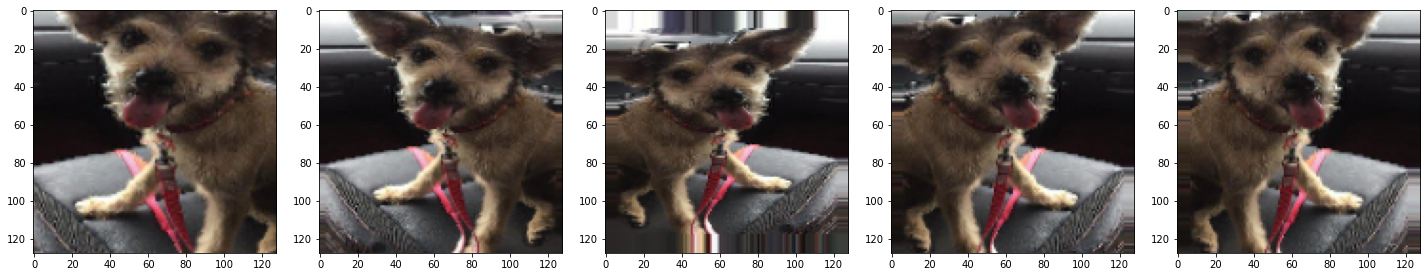

In [51]:
# plot data augmentation
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [17]:
def get_images(X, id_set):
    images = dict((pet_id, None) for pet_id in X.index)

    for image_file in os.listdir('data/train_images'): 
        pet_id = image_file.split('-')[0]
        if pet_id in id_set:
            image = cv2.imread('data/train_images'+r'/'+image_file)
            image = cv2.resize(image, img_dim)
            images[pet_id] = image           
    return images

In [18]:
train_images = get_images(X_train, train_id)
val_images = get_images(X_val, val_id)
test_images = get_images(X_test, test_id)

In [19]:
def fill_missing(images):
    for k, v in images.items():
        if v is None:
            images[k] = np.zeros((128, 128, 3))
    return images

In [20]:
train_immges = fill_missing(train_images)
val_images = fill_missing(val_images)
test_images = fill_missing(test_images)

In [21]:
train_images = train_images.values()
val_images = val_images.values()
test_images = test_images.values()

In [22]:
train_images = np.array(list(train_images))
val_images = np.array(list(val_images))
test_images = np.array(list(test_images))

In [23]:
train_images = train_images/255.
val_images = val_images/255.
test_images = test_images/255.

## Image

### Model 1

In [63]:
densenet_base = applications.DenseNet201(weights='imagenet', include_top=False, input_shape = (128, 128, 3))
densenet_base.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [64]:
for layer in densenet_base.layers:
    layer.trainable = False

In [65]:
def conv_model():
    model = Sequential()
    model.add(densenet_base)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

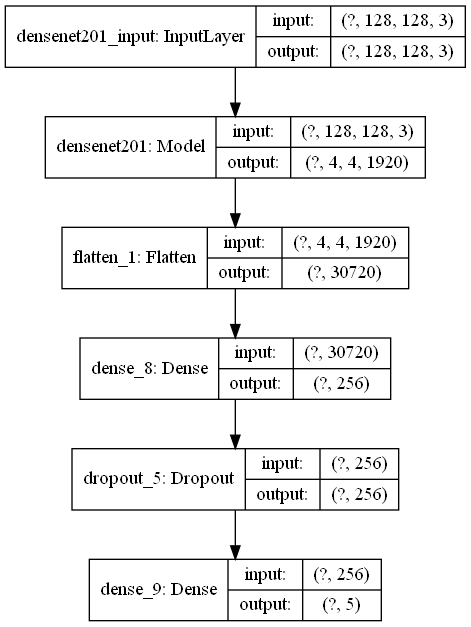

In [66]:
cnn = conv_model()
plot_model(cnn, show_shapes=True, show_layer_names=True)

In [67]:
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint(
    'cnn1.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

cnn_history = cnn.fit(train_generator,
                      epochs=epochs,
                      verbose=1,
                      validation_data=validation_generator,
                      callbacks=[checkpoint])

Epoch 1/25
83/83 [==============================] - 112s 1s/step - loss: 2.2835 - accuracy: 0.2711 - val_loss: 1.3853 - val_accuracy: 0.2774

Epoch 00001: val_accuracy improved from -inf to 0.27745, saving model to cnn1.h5
Epoch 2/25
83/83 [==============================] - 49s 592ms/step - loss: 1.4851 - accuracy: 0.2854 - val_loss: 1.4704 - val_accuracy: 0.3302

Epoch 00002: val_accuracy improved from 0.27745 to 0.33021, saving model to cnn1.h5
Epoch 3/25
83/83 [==============================] - 51s 618ms/step - loss: 1.4745 - accuracy: 0.2921 - val_loss: 1.3721 - val_accuracy: 0.3140

Epoch 00003: val_accuracy did not improve from 0.33021
Epoch 4/25
83/83 [==============================] - 53s 639ms/step - loss: 1.4668 - accuracy: 0.3001 - val_loss: 1.4834 - val_accuracy: 0.3319

Epoch 00004: val_accuracy improved from 0.33021 to 0.33191, saving model to cnn1.h5
Epoch 5/25
83/83 [==============================] - 54s 647ms/step - loss: 1.4558 - accuracy: 0.3059 - val_loss: 1.4298 - 

In [68]:
cnn = load_model('cnn1.h5')
cnn_accuracy = cnn.evaluate(test_generator)
print("Accuracy: ", cnn_accuracy[1])

23/23 [==============================] - 28s 1s/step
Accuracy:  0.33401569724082947


In [69]:
y_pred_train = np.argmax(cnn.predict_generator(train_generator), axis=1)
true_labels_train = train_generator.classes
p = precision_score(true_labels_train, y_pred_train, average='weighted')
r = recall_score(true_labels_train, y_pred_train, average='weighted')
f = f1_score(true_labels_train, y_pred_train, average='weighted')
print(p)
print(r)
print(f)

0.25009356864689747
0.2629432960364119
0.22181070570614184


In [70]:
y_pred = np.argmax(cnn.predict_generator(test_generator), axis=1)
true_labels = test_generator.classes
p = precision_score(true_labels, y_pred, average='weighted')
r = recall_score(true_labels, y_pred, average='weighted')
f = f1_score(true_labels, y_pred, average='weighted')
print(p)
print(r)
print(f)

0.2563273382912553
0.2664619583759809
0.2243188878096341


### Model 2

In [71]:
densenet_base = applications.DenseNet201(weights='imagenet', include_top=False, input_shape = (128, 128, 3))
for layer in densenet_base.layers[:500]:
    layer.trainable = False

In [72]:
def conv_model():
    model = Sequential()
    model.add(densenet_base)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [73]:
cnn = conv_model()
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint(
    'cnn2.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

cnn_history = cnn.fit(train_generator,
                      epochs=15,
                      verbose=1,
                      validation_data=validation_generator,
                      callbacks=[checkpoint])

Epoch 1/15
83/83 [==============================] - 176s 2s/step - loss: 2.5045 - accuracy: 0.2472 - val_loss: 1.4326 - val_accuracy: 0.2774

Epoch 00001: val_accuracy improved from -inf to 0.27745, saving model to cnn2.h5
Epoch 2/15
83/83 [==============================] - 548s 7s/step - loss: 1.5253 - accuracy: 0.2687 - val_loss: 1.3880 - val_accuracy: 0.2757

Epoch 00002: val_accuracy did not improve from 0.27745
Epoch 3/15
83/83 [==============================] - 548s 7s/step - loss: 1.5139 - accuracy: 0.2708 - val_loss: 1.5890 - val_accuracy: 0.2757

Epoch 00003: val_accuracy did not improve from 0.27745
Epoch 4/15
83/83 [==============================] - 546s 7s/step - loss: 1.4975 - accuracy: 0.2715 - val_loss: 1.4302 - val_accuracy: 0.2953

Epoch 00004: val_accuracy improved from 0.27745 to 0.29532, saving model to cnn2.h5
Epoch 5/15
83/83 [==============================] - 548s 7s/step - loss: 1.4918 - accuracy: 0.2866 - val_loss: 1.5269 - val_accuracy: 0.3149

Epoch 00005: va

In [74]:
cnn = load_model('cnn2.h5')
cnn_accuracy = cnn.evaluate(test_generator)
print("Accuracy: ", cnn_accuracy[1])

23/23 [==============================] - 20s 848ms/step
Accuracy:  0.3172978460788727


In [75]:
y_pred_train = np.argmax(cnn.predict_generator(train_generator), axis=1)
true_labels_train = train_generator.classes
p = precision_score(true_labels_train, y_pred_train, average='weighted')
r = recall_score(true_labels_train, y_pred_train, average='weighted')
f = f1_score(true_labels_train, y_pred_train, average='weighted')
print(p)
print(r)
print(f)

0.14782704172162356
0.27299450028446803
0.18424468940580496


In [76]:
y_pred = np.argmax(cnn.predict_generator(test_generator), axis=1)
true_labels = test_generator.classes
p = precision_score(true_labels, y_pred, average='weighted')
r = recall_score(true_labels, y_pred, average='weighted')
f = f1_score(true_labels, y_pred, average='weighted')
print(p)
print(r)
print(f)

0.15006518487458068
0.27533265097236437
0.19180027101839012


### Model 3

In [257]:
densenet_base = applications.DenseNet201(weights='imagenet', include_top=False, input_shape = (128, 128, 3))
densenet_base.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_9 (ZeroPadding2D (None, 134, 134, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_9[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [258]:
for layer in densenet_base.layers[:650]:
    layer.trainable = False

In [259]:
def conv_model():
    model = Sequential()
    model.add(densenet_base)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

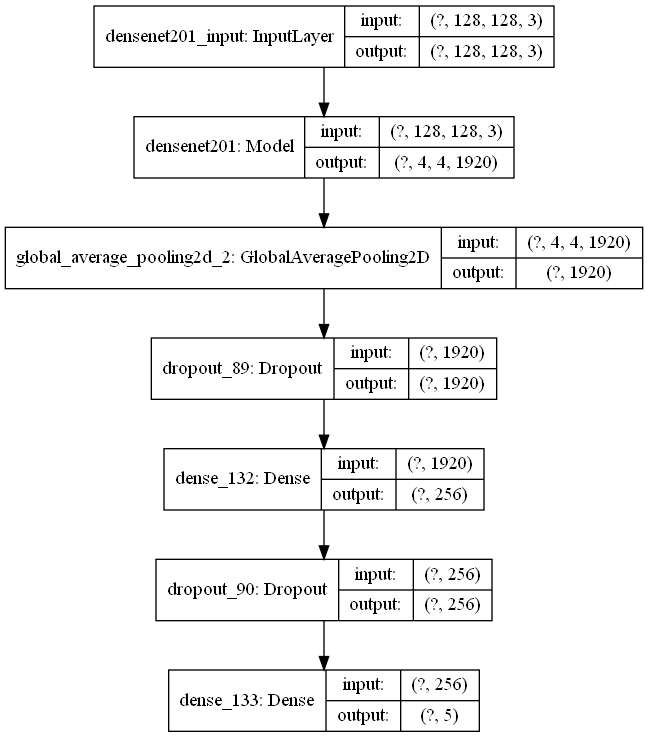

In [260]:
cnn = conv_model()
plot_model(cnn, show_shapes=True, show_layer_names=True)

In [261]:
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint(
    'cnn3.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

cnn_history = cnn.fit(train_generator,
                      epochs=epochs,
                      verbose=1,
                      validation_data=validation_generator,
                      callbacks=[checkpoint])

Epoch 1/25
83/83 [==============================] - 67s 805ms/step - loss: 1.6143 - accuracy: 0.2798 - val_loss: 1.3036 - val_accuracy: 0.3234

Epoch 00001: val_accuracy improved from -inf to 0.32340, saving model to cnn3.h5
Epoch 2/25
83/83 [==============================] - 57s 683ms/step - loss: 1.4529 - accuracy: 0.3158 - val_loss: 1.3911 - val_accuracy: 0.3455

Epoch 00002: val_accuracy improved from 0.32340 to 0.34553, saving model to cnn3.h5
Epoch 3/25
83/83 [==============================] - 57s 692ms/step - loss: 1.4285 - accuracy: 0.3309 - val_loss: 1.5980 - val_accuracy: 0.3396

Epoch 00003: val_accuracy did not improve from 0.34553
Epoch 4/25
83/83 [==============================] - 57s 691ms/step - loss: 1.4088 - accuracy: 0.3499 - val_loss: 1.4744 - val_accuracy: 0.3362

Epoch 00004: val_accuracy did not improve from 0.34553
Epoch 5/25
83/83 [==============================] - 58s 693ms/step - loss: 1.3768 - accuracy: 0.3705 - val_loss: 1.6400 - val_accuracy: 0.3226

Epoch

In [262]:
cnn = load_model('cnn3.h5')
cnn_accuracy = cnn.evaluate(test_generator)
print("Accuracy: ", cnn_accuracy[1])

23/23 [==============================] - 22s 938ms/step
Accuracy:  0.32480382919311523


In [266]:
y_pred_train = np.argmax(cnn.predict_generator(train_generator), axis=1)
true_labels_train = train_generator.classes
p = precision_score(true_labels_train, y_pred_train, average='weighted')
r = recall_score(true_labels_train, y_pred_train, average='weighted')
f = f1_score(true_labels_train, y_pred_train, average='weighted')
print(p)
print(r)
print(f)

0.24674796982402142
0.2709084012895885
0.2090196983879579


In [267]:
y_pred = np.argmax(cnn.predict_generator(test_generator), axis=1)
true_labels = test_generator.classes
p = precision_score(true_labels, y_pred, average='weighted')
r = recall_score(true_labels, y_pred, average='weighted')
f = f1_score(true_labels, y_pred, average='weighted')
print(p)
print(r)
print(f)

0.2550711004753073
0.26475605595359947
0.20823555688113285


### Model 4

In [268]:
vgg_base = applications.VGG19(weights='imagenet', include_top=False, input_shape = (128, 128, 3))
vgg_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [272]:
for layer in vgg_base.layers[:10]:
    layer.trainable = False

In [273]:
def conv_model():
    model = Sequential()
    model.add(vgg_base)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

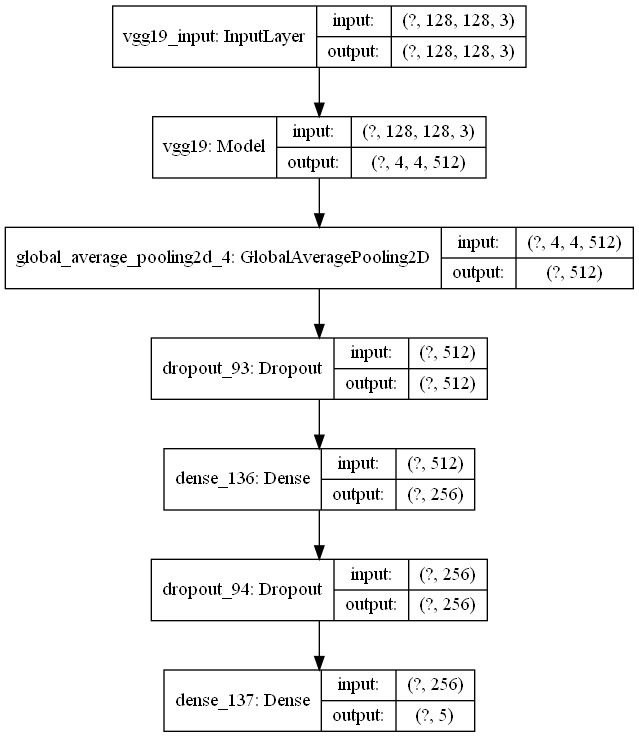

In [274]:
cnn = conv_model()
plot_model(cnn, show_shapes=True, show_layer_names=True)

In [275]:
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint(
    'cnn4.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

cnn_history = cnn.fit(train_generator,
                      epochs=epochs,
                      verbose=1,
                      validation_data=validation_generator,
                      callbacks=[checkpoint])

Epoch 1/25
83/83 [==============================] - 67s 811ms/step - loss: 1.8051 - accuracy: 0.2587 - val_loss: 1.5452 - val_accuracy: 0.2757

Epoch 00001: val_accuracy improved from -inf to 0.27574, saving model to cnn4.h5
Epoch 2/25
83/83 [==============================] - 66s 792ms/step - loss: 1.4811 - accuracy: 0.2652 - val_loss: 1.4388 - val_accuracy: 0.2757

Epoch 00002: val_accuracy did not improve from 0.27574
Epoch 3/25
83/83 [==============================] - 66s 798ms/step - loss: 1.4760 - accuracy: 0.2764 - val_loss: 1.4069 - val_accuracy: 0.2757

Epoch 00003: val_accuracy did not improve from 0.27574
Epoch 4/25
83/83 [==============================] - 66s 801ms/step - loss: 1.4804 - accuracy: 0.2707 - val_loss: 1.3732 - val_accuracy: 0.2723

Epoch 00004: val_accuracy did not improve from 0.27574
Epoch 5/25
83/83 [==============================] - 67s 810ms/step - loss: 1.4765 - accuracy: 0.2701 - val_loss: 1.3863 - val_accuracy: 0.2774

Epoch 00005: val_accuracy improved

In [276]:
cnn = load_model('cnn4.h5')
cnn_accuracy = cnn.evaluate(test_generator)
print("Accuracy: ", cnn_accuracy[1])

23/23 [==============================] - 10s 453ms/step
Accuracy:  0.2739679217338562


In [277]:
y_pred_train = np.argmax(cnn.predict_generator(train_generator), axis=1)
true_labels_train = train_generator.classes
p = precision_score(true_labels_train, y_pred_train, average='weighted')
r = recall_score(true_labels_train, y_pred_train, average='weighted')
f = f1_score(true_labels_train, y_pred_train, average='weighted')
print(p)
print(r)
print(f)

0.1457610372998589
0.2709084012895885
0.11714198303388386


In [278]:
y_pred = np.argmax(cnn.predict_generator(test_generator), axis=1)
true_labels = test_generator.classes
p = precision_score(true_labels, y_pred, average='weighted')
r = recall_score(true_labels, y_pred, average='weighted')
f = f1_score(true_labels, y_pred, average='weighted')
print(p)
print(r)
print(f)

0.1243756455243201
0.27294438758103035
0.12004068907636133


### Model 5

In [284]:
resnet_base = applications.ResNet152(weights='imagenet', include_top=False, input_shape = (128, 128, 3))
resnet_base.summary()

234700800/234698864 [==============================] - 5s 0us/step
Model: "resnet152"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
_______________________

In [285]:
for layer in resnet_base.layers:
    layer.trainable = False

In [286]:
def conv_model():
    model = Sequential()
    model.add(resnet_base)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

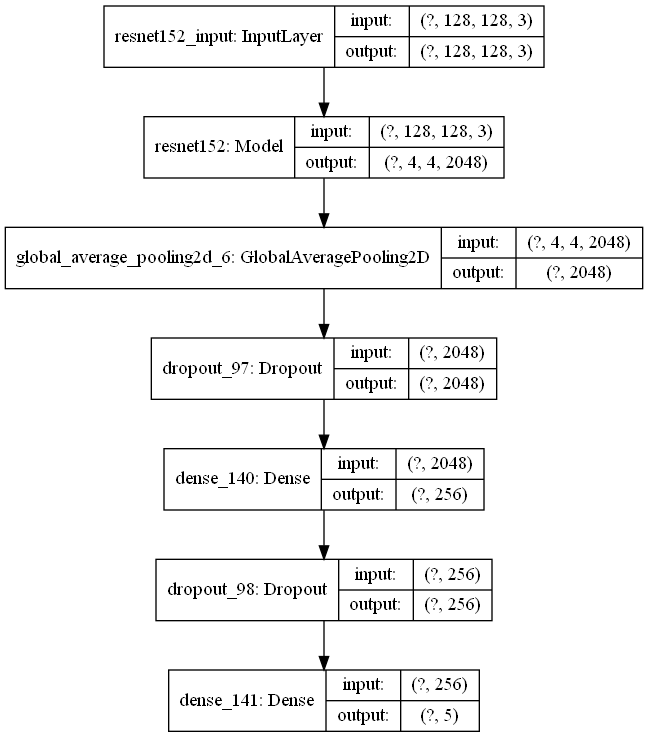

In [287]:
cnn = conv_model()
plot_model(cnn, show_shapes=True, show_layer_names=True)

In [288]:
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint(
    'cnn5.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

cnn_history = cnn.fit(train_generator,
                      epochs=epochs,
                      verbose=1,
                      validation_data=validation_generator,
                      callbacks=[checkpoint])

Epoch 1/25
83/83 [==============================] - 72s 872ms/step - loss: 1.6812 - accuracy: 0.2713 - val_loss: 1.5277 - val_accuracy: 0.2723

Epoch 00001: val_accuracy improved from -inf to 0.27234, saving model to cnn5.h5
Epoch 2/25
83/83 [==============================] - 63s 763ms/step - loss: 1.4778 - accuracy: 0.2875 - val_loss: 1.5062 - val_accuracy: 0.2723

Epoch 00002: val_accuracy did not improve from 0.27234
Epoch 3/25
83/83 [==============================] - 70s 838ms/step - loss: 1.4614 - accuracy: 0.3085 - val_loss: 1.4783 - val_accuracy: 0.2723

Epoch 00003: val_accuracy did not improve from 0.27234
Epoch 4/25
83/83 [==============================] - 69s 833ms/step - loss: 1.4519 - accuracy: 0.3239 - val_loss: 1.5116 - val_accuracy: 0.2723

Epoch 00004: val_accuracy did not improve from 0.27234
Epoch 5/25
83/83 [==============================] - 69s 837ms/step - loss: 1.4446 - accuracy: 0.3243 - val_loss: 1.5549 - val_accuracy: 0.2732

Epoch 00005: val_accuracy improved

In [289]:
cnn = load_model('cnn5.h5')
cnn_accuracy = cnn.evaluate(test_generator)
print("Accuracy: ", cnn_accuracy[1])

23/23 [==============================] - 23s 989ms/step
Accuracy:  0.2671443223953247


In [290]:
y_pred_train = np.argmax(cnn.predict_generator(train_generator), axis=1)
true_labels_train = train_generator.classes
p = precision_score(true_labels_train, y_pred_train, average='weighted')
r = recall_score(true_labels_train, y_pred_train, average='weighted')
f = f1_score(true_labels_train, y_pred_train, average='weighted')
print(p)
print(r)
print(f)

0.11885718922065873
0.2671154940261711
0.14454339008090766


In [291]:
y_pred = np.argmax(cnn.predict_generator(test_generator), axis=1)
true_labels = test_generator.classes
p = precision_score(true_labels, y_pred, average='weighted')
r = recall_score(true_labels, y_pred, average='weighted')
f = f1_score(true_labels, y_pred, average='weighted')
print(p)
print(r)
print(f)

0.1164189749410577
0.2640736949846469
0.141445766825696


## Structured Data

### Model 1

In [57]:
def mlp_model():
    model = Sequential()
    model.add(Dense(256, activation = 'relu', kernel_initializer='he_uniform', input_shape=(X_train.shape[1],)))
    model.add(Dense(256, activation = 'relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    return model

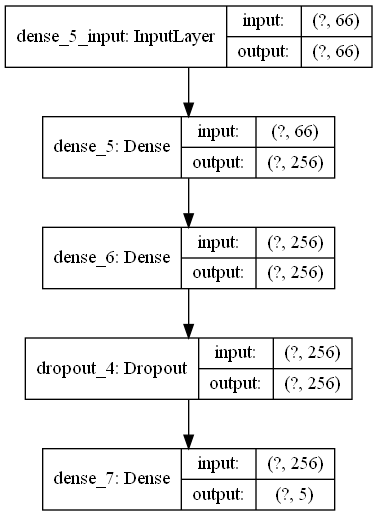

In [58]:
mlp = mlp_model()
plot_model(mlp, show_shapes=True, show_layer_names=True)

In [60]:
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint(
    'mlp1.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

mlp_history = mlp.fit(X_train, y_cat_train,
                            epochs=epochs,
                            verbose=1,
                            validation_data=(X_val, y_cat_val),
                            batch_size=batch_size, callbacks=[checkpoint])

Train on 10794 samples, validate on 1200 samples
Epoch 1/25
10794/10794 [==============================] - 0s 35us/step - loss: 16.5319 - accuracy: 0.2456 - val_loss: 2.0594 - val_accuracy: 0.2900

Epoch 00001: val_accuracy improved from -inf to 0.29000, saving model to mlp1.h5
Epoch 2/25
10794/10794 [==============================] - 0s 24us/step - loss: 2.0564 - accuracy: 0.2600 - val_loss: 1.6069 - val_accuracy: 0.2692

Epoch 00002: val_accuracy did not improve from 0.29000
Epoch 3/25
10794/10794 [==============================] - 0s 24us/step - loss: 1.6488 - accuracy: 0.2718 - val_loss: 1.5054 - val_accuracy: 0.3125

Epoch 00003: val_accuracy improved from 0.29000 to 0.31250, saving model to mlp1.h5
Epoch 4/25
10794/10794 [==============================] - 0s 25us/step - loss: 1.5498 - accuracy: 0.2840 - val_loss: 1.4729 - val_accuracy: 0.3033

Epoch 00004: val_accuracy did not improve from 0.31250
Epoch 5/25
10794/10794 [==============================] - 0s 24us/step - loss: 1.48

In [61]:
mlp = load_model('mlp1.h5')
mlp.evaluate(X_test, y_cat_test)[1]

2999/2999 [==============================] - 0s 57us/step


0.3381127119064331

In [62]:
y_pred_train = np.argmax(mlp.predict(X_train), axis=1)
p = precision_score(y_train, y_pred_train, average='weighted')
r = recall_score(y_train, y_pred_train, average='weighted')
f = f1_score(y_train, y_pred_train, average='weighted')
print(p)
print(r)
print(f)

0.44027706478767886
0.3516768575134334
0.266931685440226


In [60]:
y_pred = np.argmax(mlp.predict(X_test), axis=1)
p = precision_score(y_test, y_pred, average='weighted')
r = recall_score(y_test, y_pred, average='weighted')
f = f1_score(y_test, y_pred, average='weighted')
print(p)
print(r)
print(f)

0.3360252160806997
0.34044681560520174
0.25344263641611686


### Model 2

In [241]:
def mlp_model():
    model = Sequential()
    model.add(Dense(512, activation = 'relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    return model

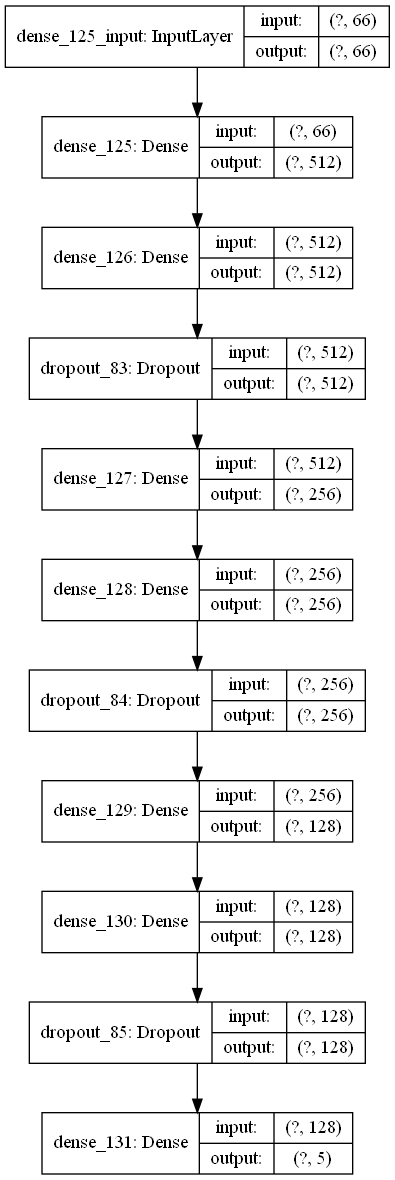

In [242]:
mlp = mlp_model()
plot_model(mlp, show_shapes=True, show_layer_names=True)

In [243]:
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint(
    'mlp2.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

mlp_history = mlp.fit(X_train, y_cat_train,
                            epochs=50,
                            verbose=1,
                            validation_data=(X_val, y_cat_val),
                            batch_size=batch_size, callbacks=[checkpoint])

Train on 10794 samples, validate on 1200 samples
Epoch 1/50
10794/10794 [==============================] - 1s 86us/step - loss: 1.9695 - accuracy: 0.2503 - val_loss: 1.5065 - val_accuracy: 0.2800

Epoch 00001: val_accuracy improved from -inf to 0.28000, saving model to mlp2.h5
Epoch 2/50
10794/10794 [==============================] - 1s 49us/step - loss: 1.5191 - accuracy: 0.2732 - val_loss: 1.4754 - val_accuracy: 0.2925

Epoch 00002: val_accuracy improved from 0.28000 to 0.29250, saving model to mlp2.h5
Epoch 3/50
10794/10794 [==============================] - 1s 48us/step - loss: 1.4869 - accuracy: 0.2768 - val_loss: 1.4650 - val_accuracy: 0.2758

Epoch 00003: val_accuracy did not improve from 0.29250
Epoch 4/50
10794/10794 [==============================] - 1s 47us/step - loss: 1.4788 - accuracy: 0.2887 - val_loss: 1.4586 - val_accuracy: 0.2883

Epoch 00004: val_accuracy did not improve from 0.29250
Epoch 5/50
10794/10794 [==============================] - 1s 48us/step - loss: 1.471

10794/10794 [==============================] - 1s 49us/step - loss: 1.3379 - accuracy: 0.4014 - val_loss: 1.3419 - val_accuracy: 0.4083

Epoch 00039: val_accuracy did not improve from 0.40833
Epoch 40/50
10794/10794 [==============================] - 0s 42us/step - loss: 1.3390 - accuracy: 0.4024 - val_loss: 1.3541 - val_accuracy: 0.4117

Epoch 00040: val_accuracy improved from 0.40833 to 0.41167, saving model to mlp2.h5
Epoch 41/50
10794/10794 [==============================] - 1s 50us/step - loss: 1.3370 - accuracy: 0.4047 - val_loss: 1.3495 - val_accuracy: 0.4000

Epoch 00041: val_accuracy did not improve from 0.41167
Epoch 42/50
10794/10794 [==============================] - 0s 43us/step - loss: 1.3320 - accuracy: 0.4055 - val_loss: 1.3601 - val_accuracy: 0.3883

Epoch 00042: val_accuracy did not improve from 0.41167
Epoch 43/50
10794/10794 [==============================] - 0s 42us/step - loss: 1.3330 - accuracy: 0.4003 - val_loss: 1.3563 - val_accuracy: 0.4042

Epoch 00043: val_a

In [244]:
mlp = load_model('mlp2.h5')
mlp.evaluate(X_test, y_cat_test)[1]

2999/2999 [==============================] - 0s 85us/step


0.40046682953834534

In [245]:
y_pred_train = np.argmax(mlp.predict(X_train), axis=1)
p = precision_score(y_train, y_pred_train, average='weighted')
r = recall_score(y_train, y_pred_train, average='weighted')
f = f1_score(y_train, y_pred_train, average='weighted')
print(p)
print(r)
print(f)

0.45277153501447664
0.42810820826385027
0.39260058922198204


In [246]:
y_pred = np.argmax(mlp.predict(X_test), axis=1)
p = precision_score(y_test, y_pred, average='weighted')
r = recall_score(y_test, y_pred, average='weighted')
f = f1_score(y_test, y_pred, average='weighted')
print(p)
print(r)
print(f)

0.410613869102539
0.40046682227409136
0.37084929935975264


## Text

In [56]:
desc = pet[['PetID', 'Description', 'AdoptionSpeed']]
desc.head()

,PetID,Description,AdoptionSpeed
0,86e1089a3,Nibble is a 3+ month old ball of cuteness. He ...,2
1,6296e909a,I just found it alone yesterday near my apartm...,0
2,3422e4906,Their pregnant mother was dumped by her irresp...,3
3,5842f1ff5,"Good guard dog, very alert, active, obedience ...",2
4,850a43f90,This handsome yet cute boy is up for adoption....,2


In [57]:
desc.Description.fillna('', inplace=True)

desc_train = desc[desc.PetID.isin(X_train.index)].set_index('PetID').sort_index().Description
desc_label_train = desc[desc.PetID.isin(X_train.index)].set_index('PetID').sort_index().AdoptionSpeed

desc_val = desc[desc.PetID.isin(X_val.index)].set_index('PetID').sort_index().Description
desc_label_val = desc[desc.PetID.isin(X_val.index)].set_index('PetID').sort_index().AdoptionSpeed

desc_test = desc[desc.PetID.isin(X_test.index)].set_index('PetID').sort_index().Description
desc_label_test = desc[desc.PetID.isin(X_test.index)].set_index('PetID').sort_index().AdoptionSpeed

desc_label_train = np_utils.to_categorical(desc_label_train, 5)
desc_label_val = np_utils.to_categorical(desc_label_val, 5)
desc_label_test = np_utils.to_categorical(desc_label_test, 5)

In [58]:
maxlen = max(desc_train.apply(lambda x: len(x.split())))

In [59]:
sentences_train = desc_train.values
sentences_val = desc_val.values
sentences_test = desc_test.values

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

desc_train = tokenizer.texts_to_sequences(sentences_train)
desc_val = tokenizer.texts_to_sequences(sentences_val)
desc_test  = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index)+1

In [60]:
desc_train = pad_sequences(desc_train, padding='post', maxlen=maxlen)
desc_val = pad_sequences(desc_val, padding='post', maxlen=maxlen)
desc_test = pad_sequences(desc_test, padding='post', maxlen=maxlen)

In [61]:
# extract word embeddings from the Glove
embeddings_index = dict()
f = open('glove.840B.300d.txt', 'r', errors = 'ignore', encoding='utf8')
for line in tqdm(f):
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

2196017it [03:07, 11702.30it/s]


In [62]:
# create a weight matrix
embedding_matrix = np.zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [63]:
# check how many vocabulary is covered by the pretrained model
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.7880616312897317

### Model 1

In [50]:
def nlp_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 300, input_length=maxlen, weights=[embedding_matrix], trainable=True))
    model.add(GlobalMaxPool1D())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes, activation='softmax'))
    return model

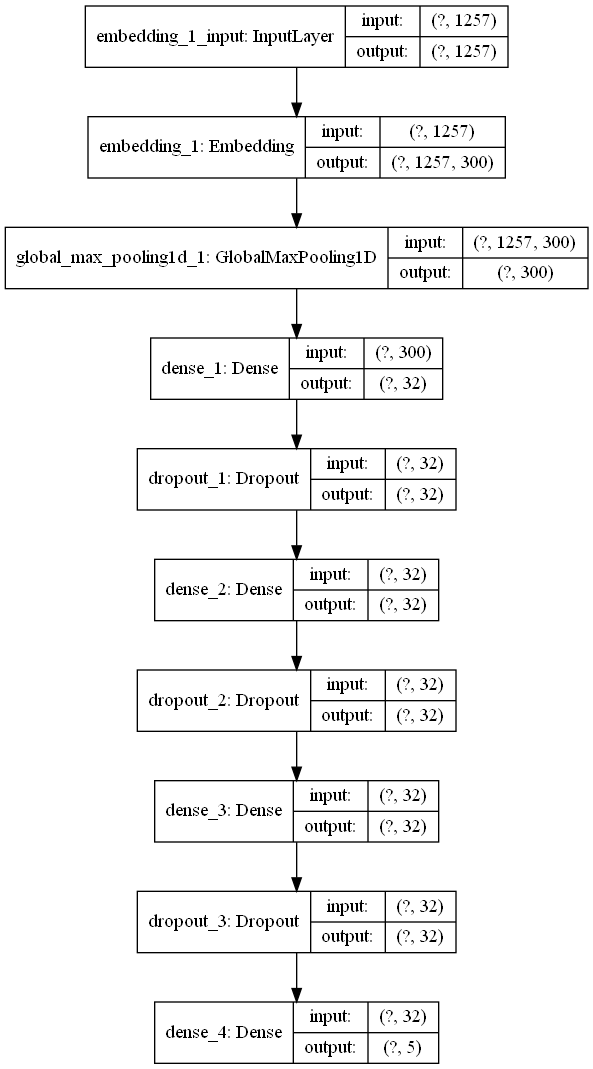

In [51]:
nlp = nlp_model()
plot_model(nlp, show_shapes=True, show_layer_names=True)

In [53]:
nlp.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

checkpoint = ModelCheckpoint(
    'nlp1.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

nlp_history = nlp.fit(desc_train, desc_label_train,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(desc_val, desc_label_val),
                         batch_size=batch_size, callbacks=[checkpoint])

Train on 10794 samples, validate on 1200 samples
Epoch 1/25
10794/10794 [==============================] - 2s 179us/step - loss: 0.7464 - accuracy: 0.6985 - val_loss: 2.5477 - val_accuracy: 0.3300

Epoch 00001: val_accuracy improved from -inf to 0.33000, saving model to nlp1.h5
Epoch 2/25
10794/10794 [==============================] - 2s 160us/step - loss: 0.7161 - accuracy: 0.7138 - val_loss: 2.6708 - val_accuracy: 0.3283

Epoch 00002: val_accuracy did not improve from 0.33000
Epoch 3/25
10794/10794 [==============================] - 2s 157us/step - loss: 0.7047 - accuracy: 0.7147 - val_loss: 2.4531 - val_accuracy: 0.3300

Epoch 00003: val_accuracy did not improve from 0.33000
Epoch 4/25
10794/10794 [==============================] - 2s 156us/step - loss: 0.6977 - accuracy: 0.7180 - val_loss: 2.7045 - val_accuracy: 0.3350

Epoch 00004: val_accuracy improved from 0.33000 to 0.33500, saving model to nlp1.h5
Epoch 5/25
10794/10794 [==============================] - 2s 159us/step - loss: 

In [54]:
nlp = load_model('nlp1.h5')
nlp.evaluate(desc_test, desc_label_test)[1]

2999/2999 [==============================] - 0s 87us/step


0.32810938358306885

In [56]:
y_pred_train = np.argmax(nlp.predict(desc_train), axis=1)
p = precision_score(np.argmax(desc_label_train, axis=1), y_pred_train, average='weighted')
r = recall_score(np.argmax(desc_label_train, axis=1), y_pred_train, average='weighted')
f = f1_score(np.argmax(desc_label_train, axis=1), y_pred_train, average='weighted')
print(p)
print(r)
print(f)

0.842620973261153
0.8598295349268112
0.8465292810201113


In [55]:
y_pred = np.argmax(nlp.predict(desc_test), axis=1)
p = precision_score(np.argmax(desc_label_test, axis=1), y_pred, average='weighted')
r = recall_score(np.argmax(desc_label_test, axis=1), y_pred, average='weighted')
f = f1_score(np.argmax(desc_label_test, axis=1), y_pred, average='weighted')
print(p)
print(r)
print(f)

0.33466939929835926
0.32810936978993
0.32316191756469764


### Model 2

In [77]:
def nlp_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 300, input_length=maxlen, weights=[embedding_matrix], trainable=True))
    model.add(GlobalMaxPool1D())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes, activation='softmax'))
    return model

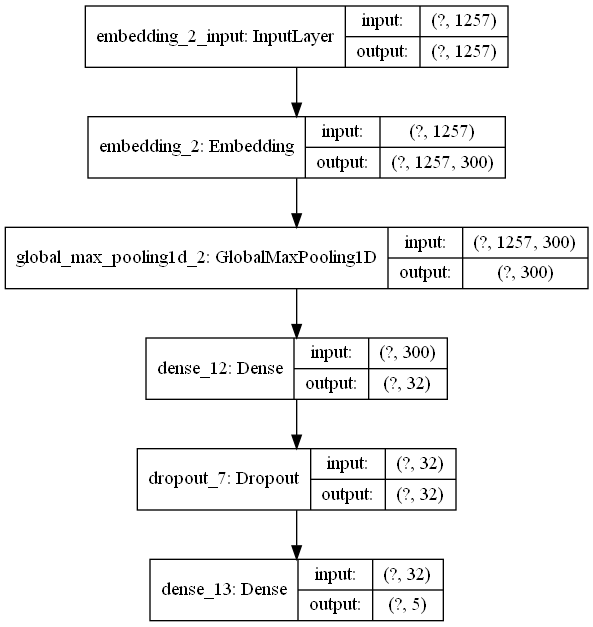

In [78]:
nlp = nlp_model()
plot_model(nlp, show_shapes=True, show_layer_names=True)

In [79]:
nlp.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

checkpoint = ModelCheckpoint(
    'nlp2.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

nlp_history = nlp.fit(desc_train, desc_label_train,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(desc_val, desc_label_val),
                         batch_size=batch_size, callbacks=[checkpoint])

Train on 10794 samples, validate on 1200 samples
Epoch 1/25
10794/10794 [==============================] - 2s 189us/step - loss: 1.5011 - accuracy: 0.2603 - val_loss: 1.4711 - val_accuracy: 0.2683

Epoch 00001: val_accuracy improved from -inf to 0.26833, saving model to nlp2.h5
Epoch 2/25
10794/10794 [==============================] - 2s 155us/step - loss: 1.4677 - accuracy: 0.2914 - val_loss: 1.4562 - val_accuracy: 0.2892

Epoch 00002: val_accuracy improved from 0.26833 to 0.28917, saving model to nlp2.h5
Epoch 3/25
10794/10794 [==============================] - 2s 155us/step - loss: 1.4462 - accuracy: 0.3117 - val_loss: 1.4428 - val_accuracy: 0.3208

Epoch 00003: val_accuracy improved from 0.28917 to 0.32083, saving model to nlp2.h5
Epoch 4/25
10794/10794 [==============================] - 2s 156us/step - loss: 1.4277 - accuracy: 0.3314 - val_loss: 1.4335 - val_accuracy: 0.3167

Epoch 00004: val_accuracy did not improve from 0.32083
Epoch 5/25
10794/10794 [===========================

In [80]:
nlp = load_model('nlp2.h5')
nlp.evaluate(desc_test, desc_label_test)[1]

2999/2999 [==============================] - 0s 103us/step


0.3604534864425659

In [81]:
y_pred_train = np.argmax(nlp.predict(desc_train), axis=1)
p = precision_score(np.argmax(desc_label_train, axis=1), y_pred_train, average='weighted')
r = recall_score(np.argmax(desc_label_train, axis=1), y_pred_train, average='weighted')
f = f1_score(np.argmax(desc_label_train, axis=1), y_pred_train, average='weighted')
print(p)
print(r)
print(f)

0.6892016942102019
0.6700018528812303
0.6528440510758994


In [82]:
y_pred = np.argmax(nlp.predict(desc_test), axis=1)
p = precision_score(np.argmax(desc_label_test, axis=1), y_pred, average='weighted')
r = recall_score(np.argmax(desc_label_test, axis=1), y_pred, average='weighted')
f = f1_score(np.argmax(desc_label_test, axis=1), y_pred, average='weighted')
print(p)
print(r)
print(f)

0.34553196622885207
0.3604534844948316
0.33497170736335835


### Model 3

In [162]:
def nlp_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 300, input_length=maxlen, weights=[embedding_matrix], trainable=True))
    model.add(Dropout(0.5))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

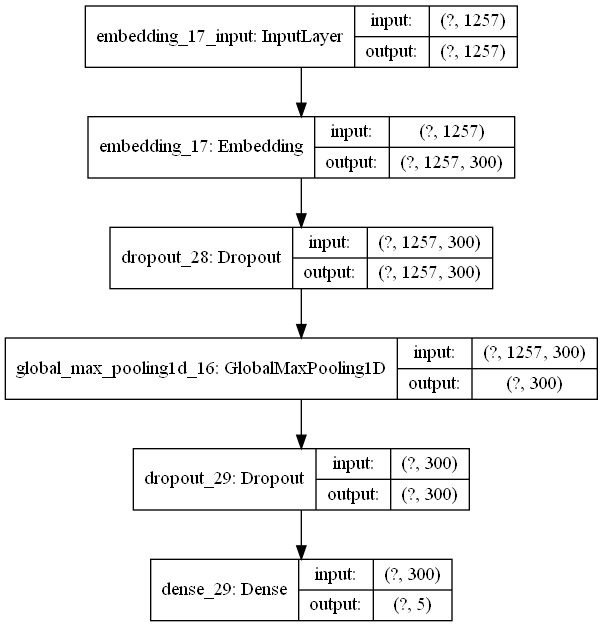

In [163]:
nlp = nlp_model()
plot_model(nlp, show_shapes=True, show_layer_names=True)

In [164]:
nlp.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

checkpoint = ModelCheckpoint(
    'nlp3.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

nlp_history = nlp.fit(desc_train, desc_label_train,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(desc_val, desc_label_val),
                         batch_size=batch_size, callbacks=[checkpoint])

Train on 10794 samples, validate on 1200 samples
Epoch 1/25
10794/10794 [==============================] - 3s 261us/step - loss: 2.2589 - accuracy: 0.2513 - val_loss: 1.4870 - val_accuracy: 0.2583

Epoch 00001: val_accuracy improved from -inf to 0.25833, saving model to nlp3.h5
Epoch 2/25
10794/10794 [==============================] - 3s 254us/step - loss: 1.9460 - accuracy: 0.2534 - val_loss: 1.4690 - val_accuracy: 0.3042

Epoch 00002: val_accuracy improved from 0.25833 to 0.30417, saving model to nlp3.h5
Epoch 3/25
10794/10794 [==============================] - 3s 253us/step - loss: 1.7264 - accuracy: 0.2700 - val_loss: 1.4630 - val_accuracy: 0.2992

Epoch 00003: val_accuracy did not improve from 0.30417
Epoch 4/25
10794/10794 [==============================] - 3s 255us/step - loss: 1.6110 - accuracy: 0.2772 - val_loss: 1.4573 - val_accuracy: 0.3108

Epoch 00004: val_accuracy improved from 0.30417 to 0.31083, saving model to nlp3.h5
Epoch 5/25
10794/10794 [===========================

In [165]:
nlp = load_model('nlp3.h5')
nlp.evaluate(desc_test, desc_label_test)[1]

2999/2999 [==============================] - 0s 90us/step


0.36445480585098267

In [166]:
y_pred_train = np.argmax(nlp.predict(desc_train), axis=1)
p = precision_score(np.argmax(desc_label_train, axis=1), y_pred_train, average='weighted')
r = recall_score(np.argmax(desc_label_train, axis=1), y_pred_train, average='weighted')
f = f1_score(np.argmax(desc_label_train, axis=1), y_pred_train, average='weighted')
print(p)
print(r)
print(f)

0.47293509248318005
0.43959607189179173
0.38586535264656285


In [167]:
y_pred = np.argmax(nlp.predict(desc_test), axis=1)
p = precision_score(np.argmax(desc_label_test, axis=1), y_pred, average='weighted')
r = recall_score(np.argmax(desc_label_test, axis=1), y_pred, average='weighted')
f = f1_score(np.argmax(desc_label_test, axis=1), y_pred, average='weighted')
print(p)
print(r)
print(f)

0.369708516900317
0.3644548182727576
0.30828831974512755


## Merge

### Model 1

In [292]:
densenet_base = applications.DenseNet201(weights='imagenet', include_top=False, input_shape = (128, 128, 3))
densenet_base.summary()

for layer in densenet_base.layers:
    layer.trainable = False

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_11 (ZeroPadding2 (None, 134, 134, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_11[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [293]:
# combine MLP, NLP and CNN
cnn = Sequential()
cnn.add(densenet_base)
cnn.add(Flatten())
cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(num_classes, activation='softmax'))

mlp = Sequential()
mlp.add(Dense(512, activation = 'relu', input_shape=(X_train.shape[1],)))
mlp.add(Dense(512, activation = 'relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(256, activation = 'relu'))
mlp.add(Dense(256, activation = 'relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(128, activation = 'relu'))
mlp.add(Dense(128, activation = 'relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(num_classes, activation='softmax'))

nlp = Sequential()
nlp.add(Embedding(vocab_size, 300, input_length=maxlen, weights=[embedding_matrix], trainable=True))
nlp.add(Dropout(0.5))
nlp.add(GlobalMaxPool1D())
nlp.add(Dropout(0.5))
nlp.add(Dense(num_classes, activation='softmax'))

model_concat = concatenate([cnn.output, mlp.output, nlp.output], axis=-1)
model_concat = Dropout(0.33)(model_concat)
model_concat = Dense(num_classes, activation='softmax')(model_concat)
model = Model(inputs=[cnn.input, mlp.input, nlp.input], outputs=model_concat)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_144_input (InputLayer)    (None, 66)           0                                            
__________________________________________________________________________________________________
dense_144 (Dense)               (None, 512)          34304       dense_144_input[0][0]            
__________________________________________________________________________________________________
dense_145 (Dense)               (None, 512)          262656      dense_144[0][0]                  
__________________________________________________________________________________________________
dropout_100 (Dropout)           (None, 512)          0           dense_145[0][0]                  
____________________________________________________________________________________________

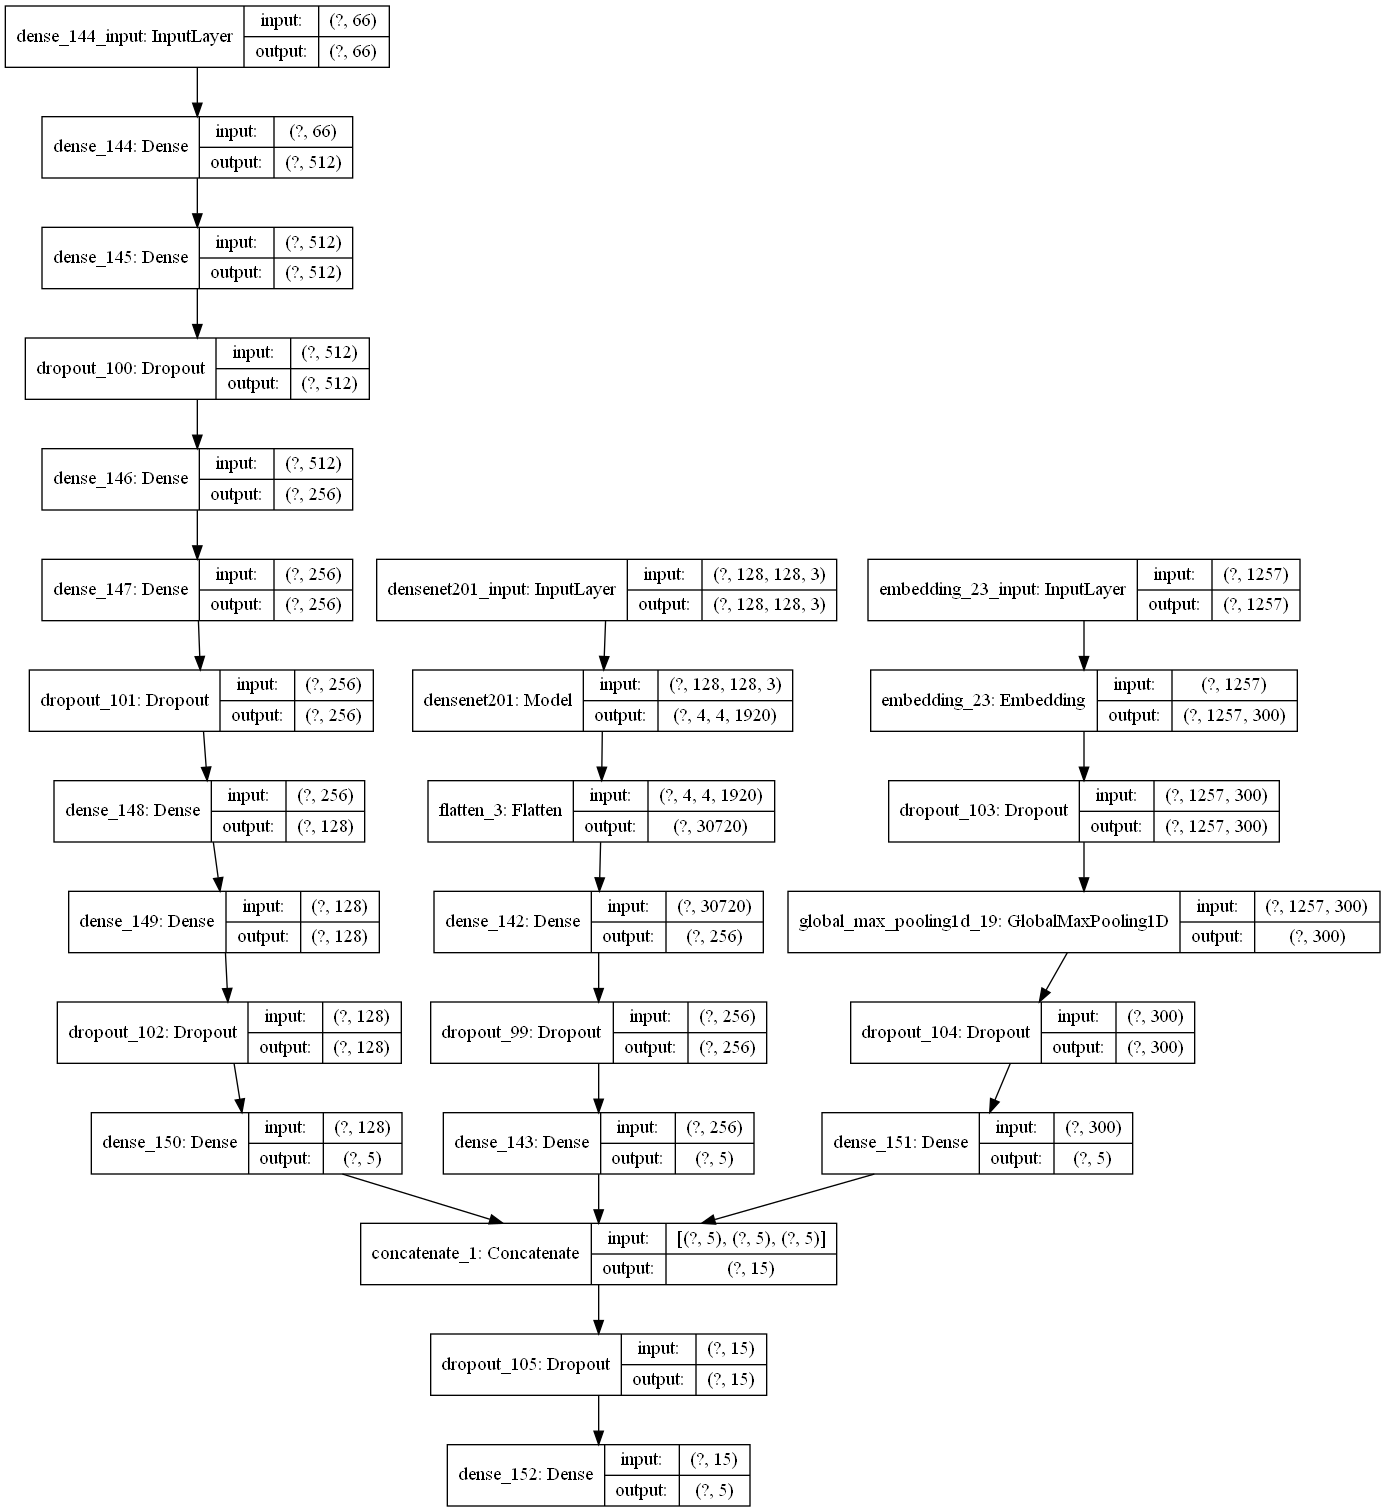

In [294]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [295]:
checkpoint = ModelCheckpoint(
    'model1.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [296]:
history = model.fit(
    [train_images, X_train, desc_train], desc_label_train,
    validation_data=([val_images, X_val, desc_val], desc_label_val),
    epochs=epochs, batch_size=batch_size, callbacks=[checkpoint])

Train on 10794 samples, validate on 1200 samples
Epoch 1/25
10794/10794 [==============================] - 75s 7ms/step - loss: 1.5651 - accuracy: 0.2653 - val_loss: 1.4876 - val_accuracy: 0.2775

Epoch 00001: val_accuracy improved from -inf to 0.27750, saving model to model1.h5
Epoch 2/25
10794/10794 [==============================] - 38s 4ms/step - loss: 1.5152 - accuracy: 0.2735 - val_loss: 1.4733 - val_accuracy: 0.2825

Epoch 00002: val_accuracy improved from 0.27750 to 0.28250, saving model to model1.h5
Epoch 3/25
10794/10794 [==============================] - 37s 3ms/step - loss: 1.4958 - accuracy: 0.2786 - val_loss: 1.4671 - val_accuracy: 0.2800

Epoch 00003: val_accuracy did not improve from 0.28250
Epoch 4/25
10794/10794 [==============================] - 37s 3ms/step - loss: 1.4906 - accuracy: 0.2761 - val_loss: 1.4643 - val_accuracy: 0.2800

Epoch 00004: val_accuracy did not improve from 0.28250
Epoch 5/25
10794/10794 [==============================] - 37s 3ms/step - loss: 1

<Figure size 2160x720 with 0 Axes>

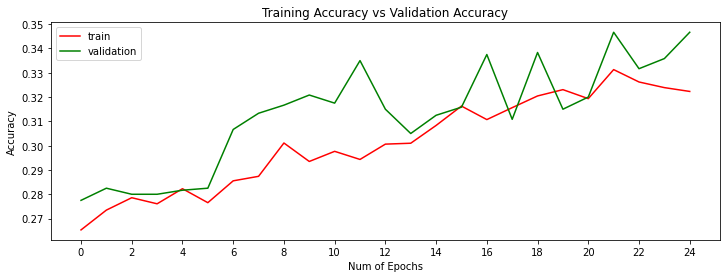

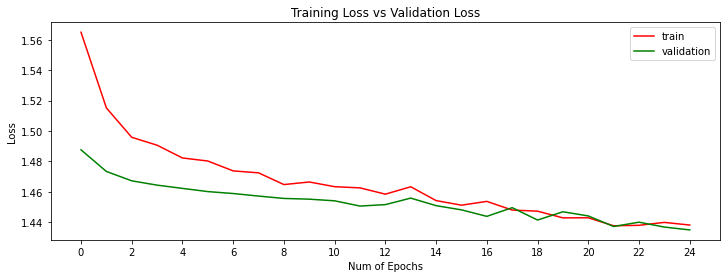

In [299]:
plt.figure(221, figsize=(30, 10))

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, epochs+1, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, epochs+1, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

In [300]:
# make predictions on the testing data
model = load_model('model1.h5')
loss, accuracy = model.evaluate([test_images, X_test, desc_test], desc_label_test)
accuracy

2999/2999 [==============================] - 26s 9ms/step


0.3381127119064331

In [301]:
y_pred_train = np.argmax(model.predict([train_images, X_train, desc_train]), axis=1)
p = precision_score(np.argmax(desc_label_train, axis=1), y_pred_train, average='weighted')
r = recall_score(np.argmax(desc_label_train, axis=1), y_pred_train, average='weighted')
f = f1_score(np.argmax(desc_label_train, axis=1), y_pred_train, average='weighted')
print(p) 
print(r)
print(f)

0.2229019845025444
0.39364461738002593
0.2824025924488398


In [302]:
y_pred = np.argmax(model.predict([test_images, X_test, desc_test]), axis=1)
p = precision_score(np.argmax(desc_label_test, axis=1), y_pred, average='weighted')
r = recall_score(np.argmax(desc_label_test, axis=1), y_pred, average='weighted')
f = f1_score(np.argmax(desc_label_test, axis=1), y_pred, average='weighted')
print(p) 
print(r)
print(f)

0.18952824201078758
0.33811270423474493
0.24150174948847994


In [303]:
print(classification_report(np.argmax(desc_label_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.00      0.00      0.00       618
           2       0.30      0.64      0.41       807
           3       0.00      0.00      0.00       652
           4       0.39      0.60      0.47       840

    accuracy                           0.34      2999
   macro avg       0.14      0.25      0.18      2999
weighted avg       0.19      0.34      0.24      2999



### Model 2

In [52]:
densenet_base = applications.DenseNet201(weights='imagenet', include_top=False, input_shape = (128, 128, 3))
densenet_base.summary()

for layer in densenet_base.layers:
    layer.trainable = False

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [64]:
# combine MLP, NLP and CNN
cnn = Sequential()
cnn.add(densenet_base)
cnn.add(GlobalAveragePooling2D())
cnn.add(BatchNormalization())
cnn.add(Dense(256, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
cnn.add(Dense(num_classes, activation='softmax'))

mlp = Sequential()
mlp.add(Dense(512, activation = 'relu', input_shape=(X_train.shape[1],)))
mlp.add(Dense(512, activation = 'relu'))
mlp.add(BatchNormalization())
mlp.add(Dropout(0.2))
mlp.add(Dense(256, activation = 'relu'))
mlp.add(Dense(256, activation = 'relu'))
mlp.add(BatchNormalization())
mlp.add(Dropout(0.2))
mlp.add(Dense(128, activation = 'relu'))
mlp.add(Dense(128, activation = 'relu'))
mlp.add(BatchNormalization())
mlp.add(Dropout(0.2))
mlp.add(Dense(num_classes, activation='softmax'))

nlp = Sequential()
nlp.add(Embedding(vocab_size, 300, input_length=maxlen, weights=[embedding_matrix], trainable=True))
nlp.add(Dropout(0.5))
nlp.add(GlobalMaxPool1D())
mlp.add(BatchNormalization())
nlp.add(Dropout(0.5))
nlp.add(Dense(num_classes, activation='softmax'))

model_concat = concatenate([cnn.output, mlp.output, nlp.output], axis=-1)
model_concat = Dropout(0.33)(model_concat)
model_concat = Dense(256, activation='softmax')(model_concat)
model_concat = Dropout(0.2)(model_concat)
model_concat = Dense(num_classes, activation='softmax')(model_concat)
model = Model(inputs=[cnn.input, mlp.input, nlp.input], outputs=model_concat)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_14_input (InputLayer)     (None, 66)           0                                            
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 512)          34304       dense_14_input[0][0]             
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 512)          262656      dense_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 512)          2048        dense_15[0][0]                   
____________________________________________________________________________________________

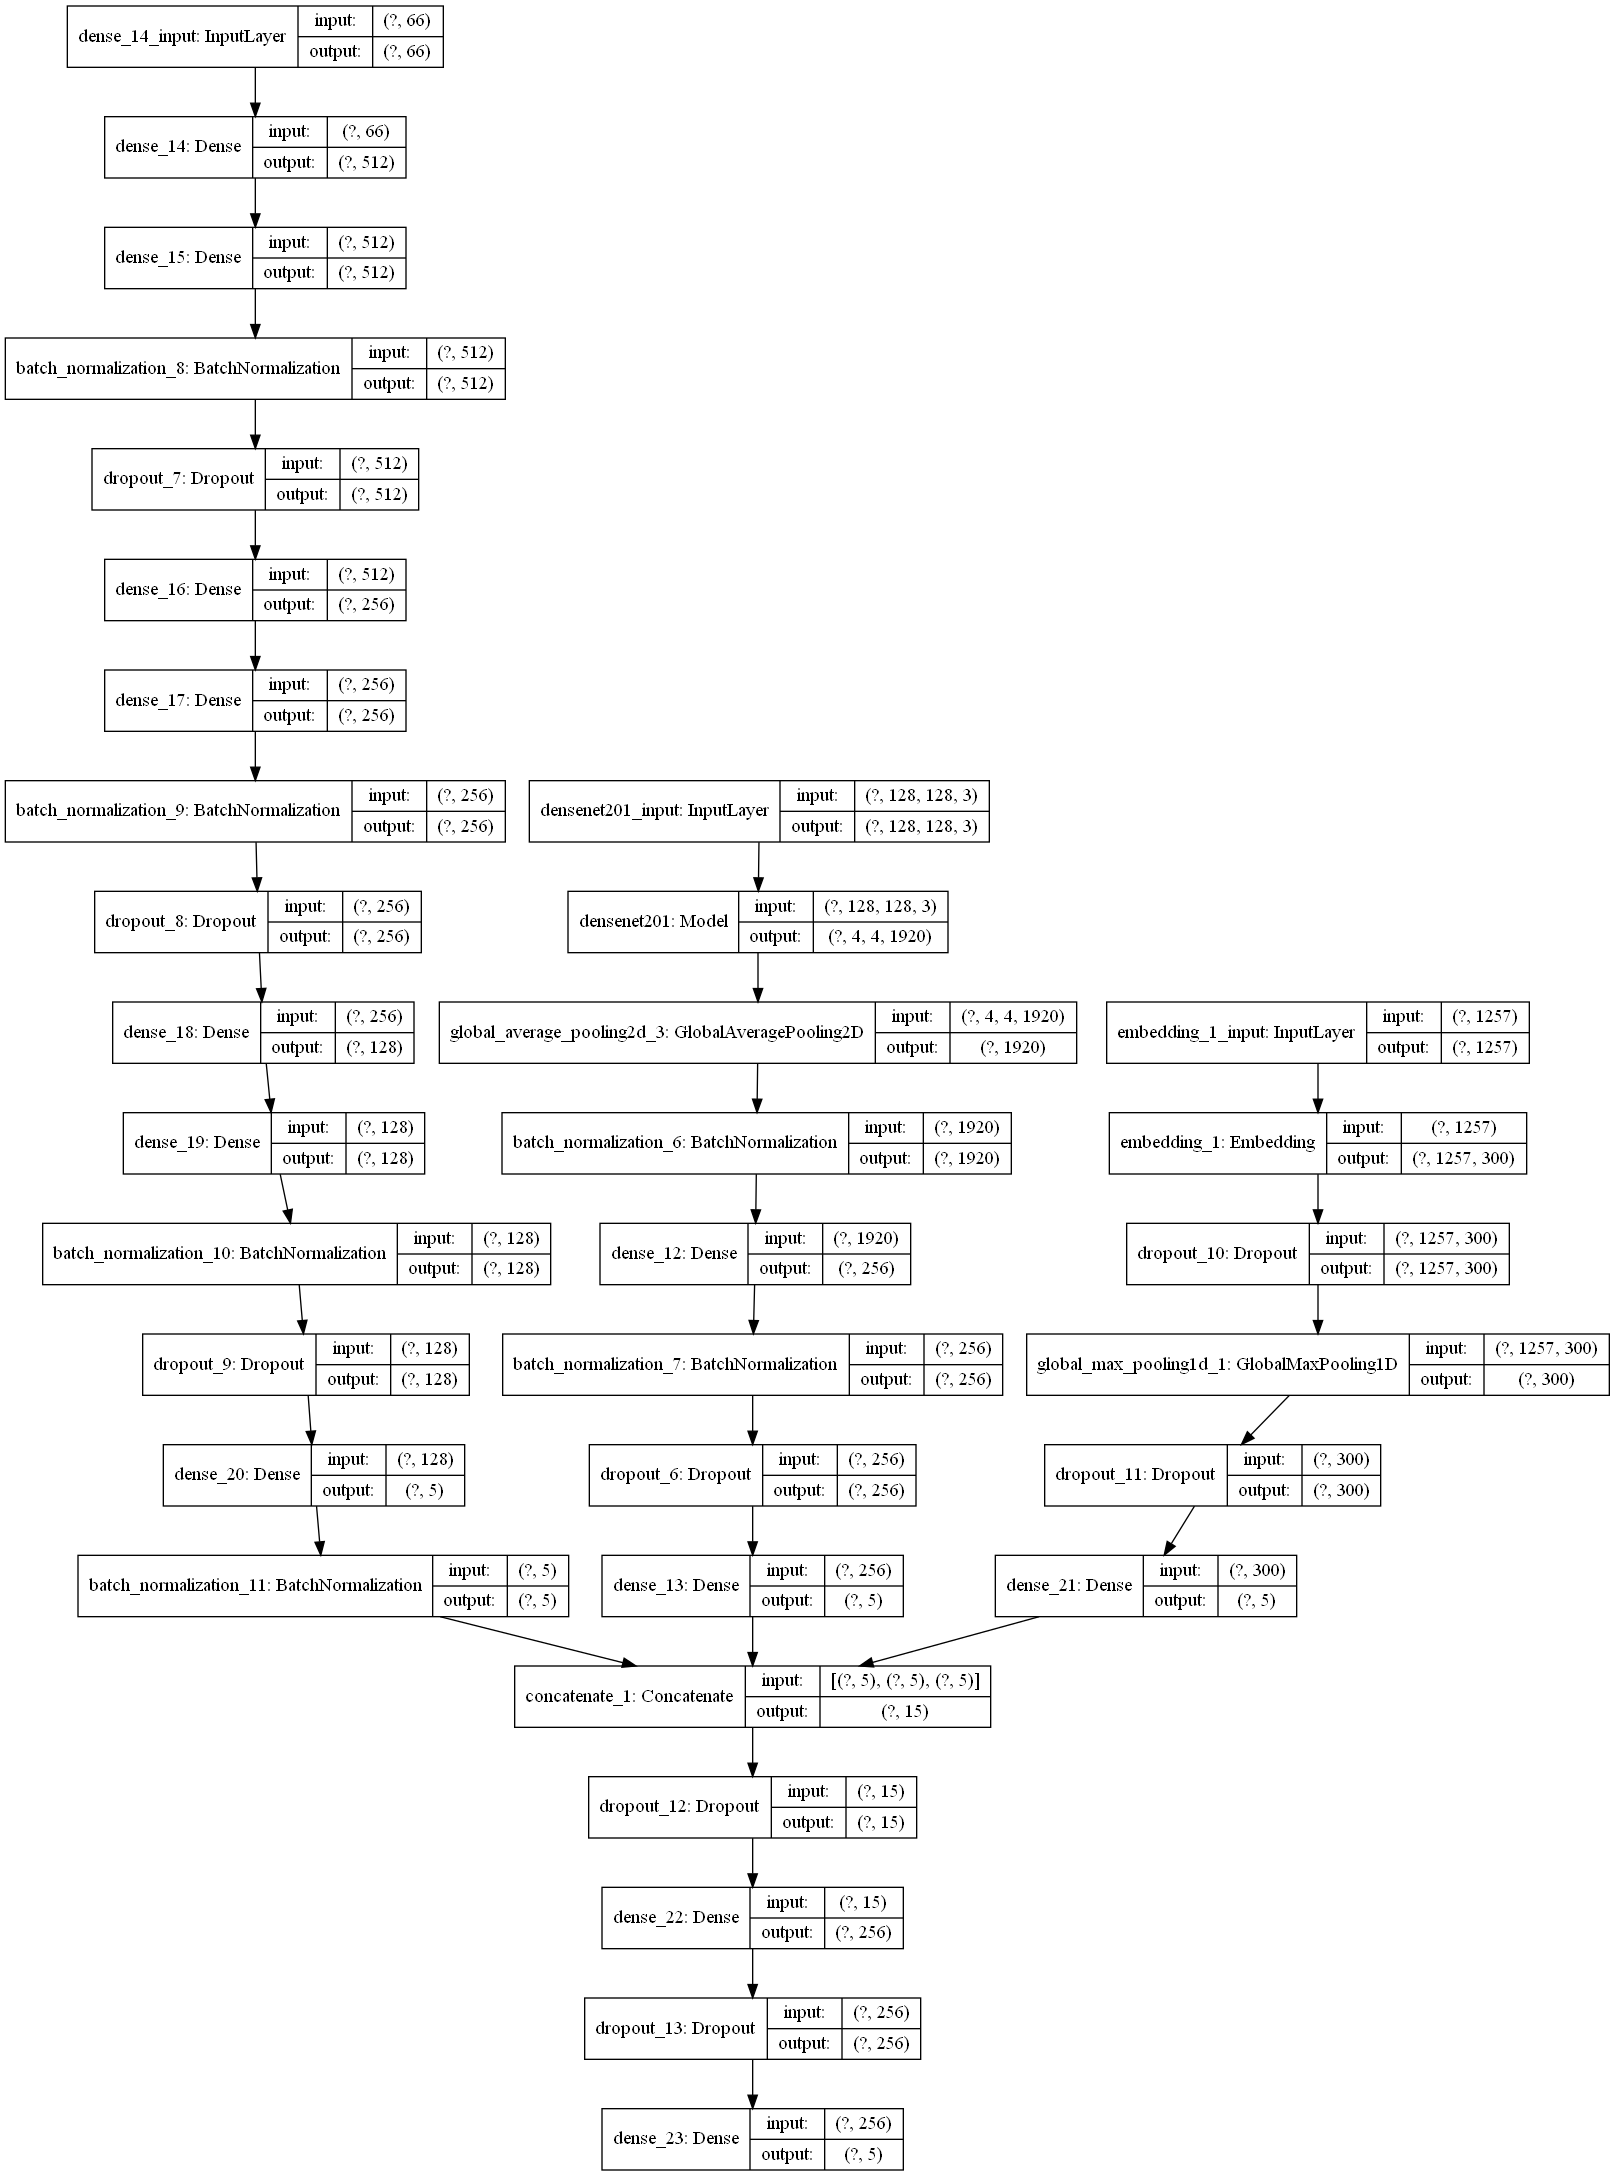

In [65]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [66]:
checkpoint = ModelCheckpoint(
    'model2.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [67]:
history = model.fit(
    [train_images, X_train, desc_train], desc_label_train,
    validation_data=([val_images, X_val, desc_val], desc_label_val),
    epochs=epochs, batch_size=batch_size, callbacks=[checkpoint])

Train on 10794 samples, validate on 1200 samples
Epoch 1/25
10794/10794 [==============================] - 77s 7ms/step - loss: 1.5853 - accuracy: 0.2748 - val_loss: 1.5631 - val_accuracy: 0.3258

Epoch 00001: val_accuracy improved from -inf to 0.32583, saving model to model2.h5
Epoch 2/25
10794/10794 [==============================] - 33s 3ms/step - loss: 1.5466 - accuracy: 0.2979 - val_loss: 1.5322 - val_accuracy: 0.2800

Epoch 00002: val_accuracy did not improve from 0.32583
Epoch 3/25
10794/10794 [==============================] - 33s 3ms/step - loss: 1.5195 - accuracy: 0.3045 - val_loss: 1.5110 - val_accuracy: 0.2992

Epoch 00003: val_accuracy did not improve from 0.32583
Epoch 4/25
10794/10794 [==============================] - 34s 3ms/step - loss: 1.4978 - accuracy: 0.3231 - val_loss: 1.4967 - val_accuracy: 0.2858

Epoch 00004: val_accuracy did not improve from 0.32583
Epoch 5/25
10794/10794 [==============================] - 34s 3ms/step - loss: 1.4758 - accuracy: 0.3344 - val_

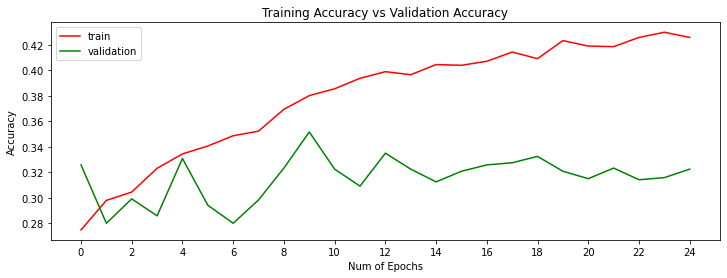

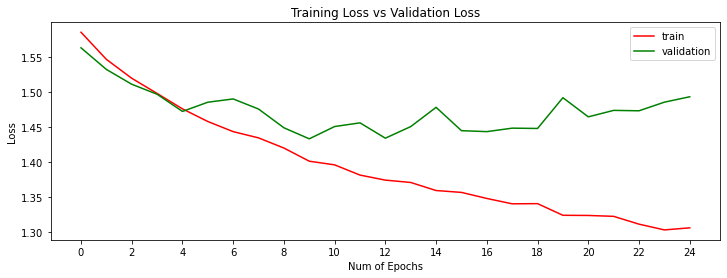

In [76]:
plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, epochs+1, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, epochs+1, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

In [69]:
# make predictions on the testing data
model = load_model('model2.h5')
loss, accuracy = model.evaluate([test_images, X_test, desc_test], desc_label_test)
accuracy

2999/2999 [==============================] - 142s 47ms/step


0.3357785940170288

In [70]:
y_pred_train = np.argmax(model.predict([train_images, X_train, desc_train]), axis=1)
p = precision_score(np.argmax(desc_label_train, axis=1), y_pred_train, average='weighted')
r = recall_score(np.argmax(desc_label_train, axis=1), y_pred_train, average='weighted')
f = f1_score(np.argmax(desc_label_train, axis=1), y_pred_train, average='weighted')
print(p) 
print(r)
print(f)

0.1997062122018822
0.3448211969612748
0.2468158138321832


In [71]:
y_pred = np.argmax(model.predict([test_images, X_test, desc_test]), axis=1)
p = precision_score(np.argmax(desc_label_test, axis=1), y_pred, average='weighted')
r = recall_score(np.argmax(desc_label_test, axis=1), y_pred, average='weighted')
f = f1_score(np.argmax(desc_label_test, axis=1), y_pred, average='weighted')
print(p) 
print(r)
print(f)

0.19721669172486245
0.3357785928642881
0.2401818207829452


In [74]:
print(classification_report(np.argmax(desc_label_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.00      0.00      0.00       618
           2       0.29      0.74      0.42       807
           3       0.00      0.00      0.00       652
           4       0.42      0.49      0.45       840

    accuracy                           0.34      2999
   macro avg       0.14      0.25      0.17      2999
weighted avg       0.20      0.34      0.24      2999

